## Things to try still
* Is it possible to subsample tips from the tree within 
ipcoal demography to replicate sampling only some lineages within the local community?

In [14]:
%load_ext autoreload
%autoreload 2
import toytree
import ipcoal
print(ipcoal.__version__, toytree.__version__)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from collections import Counter
from itertools import combinations


import BCI


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
0.4.dev1 3.0.1


In [7]:
tre = toytree.rtree.unittree(10, treeheight=1e7)
tre.draw(tree_style='p');

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="300.0px" height="300.0px" viewBox="0 0 300.0 300.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t802fc9cda1854c9bb3b63ef07ba54a0e"> 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 r0 r1 r2 r3 r4 r5 r6 r7 r8 r9 0 5000000 10000000

## Unittree with constant Ne of 1e5

In [9]:
outphy = "./analysis/sim_fastas/unittree-Ne1e5-10samples.phy"
model = ipcoal.Model(tre, Ne=1e5, recomb=0, mut=1e-8, nsamples=10)
model.sim_loci(nloci=1, nsites=1000)
model.write_concat_to_phylip(name=outphy)
_ = BCI.phylip_to_fasta(outphy, verbose=False)

wrote concat locus (100 x 1000bp) to /home/isaac/proj/IMEMEBA-BCI/jupyter-notebooks/analysis/sim_fastas/unittree-Ne1e5-10samples.phy


[54, 11, 10, 10, 10, 10, 9, 9, 8, 6, 6, 5, 4, 4, 4, 4, 3, 2, 2, 1]
Aligning..
{'r0_0': 0.0029333333333333334, 'r9_0': 0.004622222222222224, 'r2_0': 0.0017555555555555556, 'r3_0': 0.002, 'r8_0': 0.007888888888888888, 'r4_0': 0.006, 'r1_0': 0.004844444444444445, 'r7_0': 0.004311111111111111, 'r5_0': 0.0012, 'r6_0': 0.0024000000000000002}


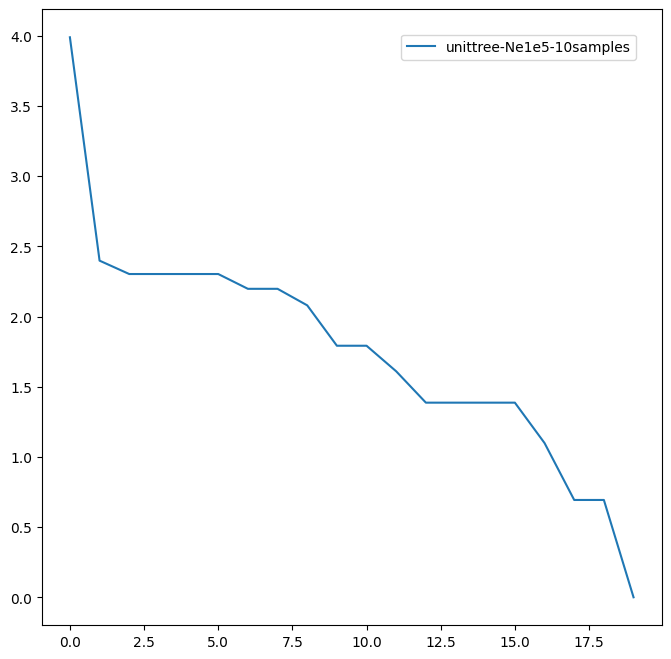

In [10]:
bci = BCI.BCI(data="./analysis/sim_fastas/unittree-Ne1e5-10samples.fasta")
bci.run(simulated=True, verbose=True)
print(bci.pis)
fig, ax = bci.plot(log=True, normalize=False)

## Unittree with lognormal NE and ancestral Ne of 1e5

In [15]:
outphy = "./analysis/sim_fastas/unittree-NeLognormal-10samples.phy"

np.random.lognormal(12, sigma=2, size=8)
tips = tre.get_tip_labels()
# Dict {tip_name:Ne}
Nes = {x:np.round(y) for x, y in zip(tips, np.random.lognormal(13, sigma=2, size=len(tips)))}
print(Nes)
# Set Nes for the tips
tre = tre.set_node_data("Ne", Nes, default=1e5)
print(tre.get_node_data("Ne"))
# Set Ne to None here to honor the Ne values on the nodes of the tree
model = ipcoal.Model(tre, Ne=None, recomb=0, mut=1e-8, nsamples=10)
model.sim_loci(nloci=1, nsites=500)
model.write_concat_to_phylip(outdir=".", name=outphy)
BCI.phylip_to_fasta(outphy, verbose=True)


{'r0': 202250.0, 'r1': 209893.0, 'r2': 328388.0, 'r3': 527930.0, 'r4': 225159.0, 'r5': 35293.0, 'r6': 144345.0, 'r7': 75656930.0, 'r8': 38066.0, 'r9': 21164.0}
0       202250.0
1       209893.0
2       328388.0
3       527930.0
4       225159.0
5        35293.0
6       144345.0
7     75656930.0
8        38066.0
9        21164.0
10      100000.0
11      100000.0
12      100000.0
13      100000.0
14      100000.0
15      100000.0
16      100000.0
17      100000.0
18      100000.0
dtype: float64
wrote concat locus (100 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/jupyter-notebooks/analysis/sim_fastas/unittree-NeLognormal-10samples.phy
./analysis/sim_fastas/unittree-NeLognormal-10samples.fasta


'./analysis/sim_fastas/unittree-NeLognormal-10samples.fasta'

In [12]:
bci2 = BCI.BCI(data="./analysis/sim_fastas/unittree-NeLognormal-10samples.fasta")
bci2.run(verbose=True)

[63, 38, 30, 26, 23, 21, 20, 17, 14, 13, 11, 9, 8, 8, 5, 3, 2, 2, 2, 2]
Aligning..


## Plot them both together

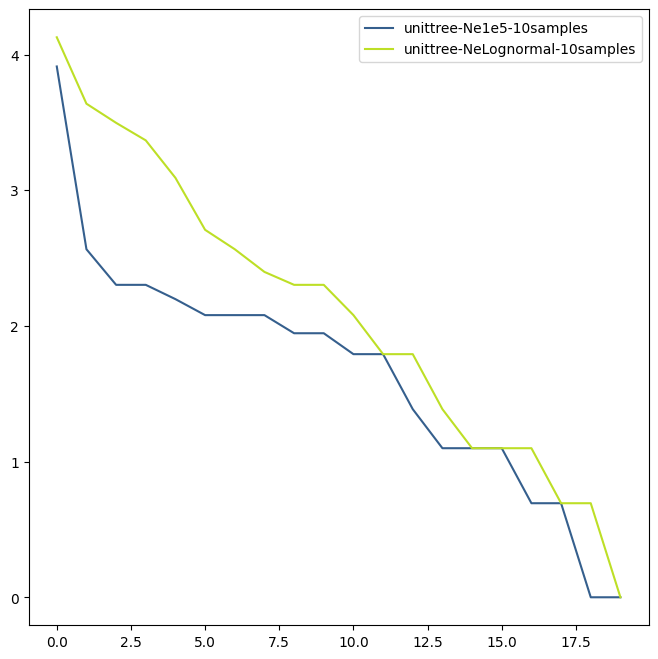

In [7]:
fix, ax = BCI.plot_multi([bci, bci2], log=True, normalize=False, cmap="viridis")

## Simulate trees with variable numbers of tips and demographic models with variable Ne

wrote concat locus (200 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/jupyter-notebooks/t20-lnFalse-Ne100000.0.phy


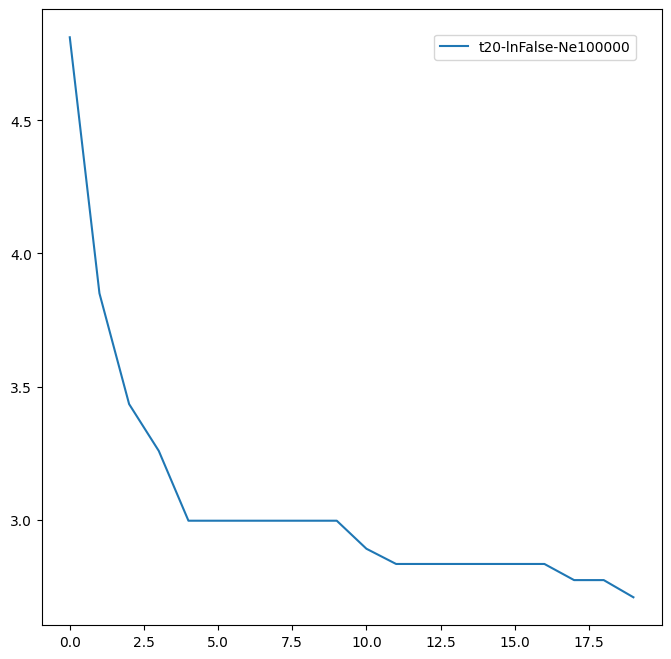

In [5]:
def sim_bci(ntips=8, treeheight=1e7, Ne=1e5, mutation_rate=3e-8, Ne_lognormal=False, verbose=False):
    """
    ntips - number of leaves on the simulated tree
    treeheight - Age of MRCA
    Ne - Ancestral Ne at all the nodes internal nodes
    mutation_rate - per base per generation mutation rate
    Ne_lognormal - Ne at the tips, can be a fixed value or 'lognormal' to indicate sampled from a lognormal distribution
    """
    tre = toytree.rtree.unittree(ntips, treeheight=treeheight)

    if Ne_lognormal:
        np.random.lognormal(12, sigma=2, size=8)
        tips = tre.get_tip_labels()
        # Dict {tip_name:Ne}
        Nes = {x:np.round(y) for x, y in zip(tips, np.random.lognormal(10, sigma=3, size=len(tips)))}
        if verbose: print(Nes)
        # Set Nes for the tips
        tre = tre.set_node_data("Ne", Nes, default=Ne)
        # Set Ne to None here to honor the Ne values on the nodes of the tree
        Ne_anc = Ne
        Ne = None
    else:
        # Use the same Ne for all nodes in the tree
        Ne_anc = Ne

    model = ipcoal.Model(tre, Ne=Ne, recomb=0, mut=mutation_rate, nsamples=10)
    model.sim_loci(nloci=1, nsites=500)
    # Write the sequence data to a file and conver to fasta
    outphy = f"t{ntips}-ln{Ne_lognormal}-Ne{str(Ne_anc)}.phy"
    model.write_concat_to_phylip(outdir=".", name=outphy)
    fasta = BCI.phylip_to_fasta(outphy, verbose=verbose)
    bci = BCI.BCI(data=fasta)
    bci.run(simulated=True, verbose=verbose)
    return bci

bci = sim_bci(ntips=20, Ne=1e5, verbose=False, Ne_lognormal=False)
fix, ax = bci.plot(log=True, normalize=False)

In [202]:
bci.bci

[100, 49, 36, 34, 25, 21, 15, 10, 8, 7, 4, 4, 4, 3, 3, 3, 2, 2, 1, 1]

## Same demography, constant Ne, same number of tips (20)

wrote concat locus (200 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/jupyter-notebooks/t20-lnFalse-Ne100000.0.phy
wrote concat locus (200 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/jupyter-notebooks/t20-lnFalse-Ne100000.0.phy
wrote concat locus (200 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/jupyter-notebooks/t20-lnFalse-Ne100000.0.phy
wrote concat locus (200 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/jupyter-notebooks/t20-lnFalse-Ne100000.0.phy
wrote concat locus (200 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/jupyter-notebooks/t20-lnFalse-Ne100000.0.phy


(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

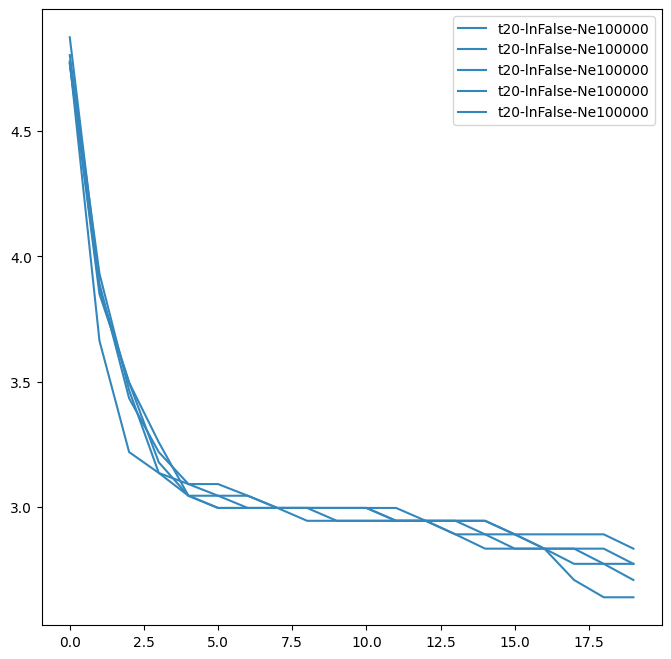

In [21]:
bcis = [sim_bci(ntips=20) for x in range(5)]
BCI.plot_multi(bcis, log=True, normalize=False)

(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

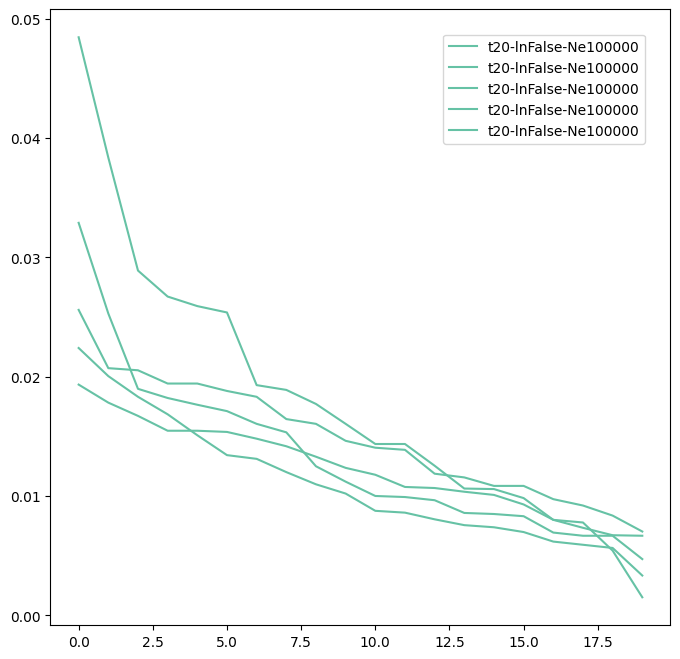

In [228]:
BCI.plot_multi(bcis, normalize=False, plot_pis=True)

## Same demography, lognormal Ne, same number of tips (20)

wrote concat locus (200 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/jupyter-notebooks/t20-lnTrue-Ne100000.0.phy
wrote concat locus (200 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/jupyter-notebooks/t20-lnTrue-Ne100000.0.phy
wrote concat locus (200 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/jupyter-notebooks/t20-lnTrue-Ne100000.0.phy
wrote concat locus (200 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/jupyter-notebooks/t20-lnTrue-Ne100000.0.phy
wrote concat locus (200 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/jupyter-notebooks/t20-lnTrue-Ne100000.0.phy


(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

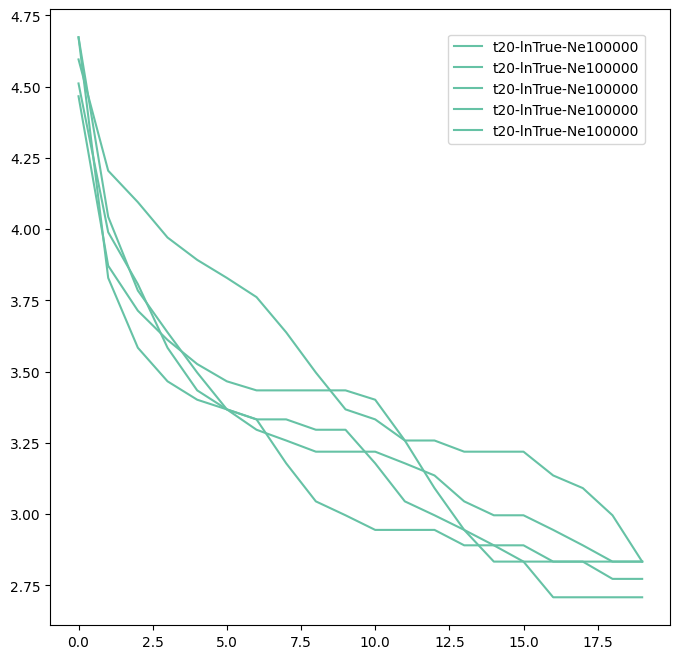

In [229]:
bcis = [sim_bci(ntips=20, Ne_lognormal=True) for x in range(5)]
BCI.plot_multi(bcis)

(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

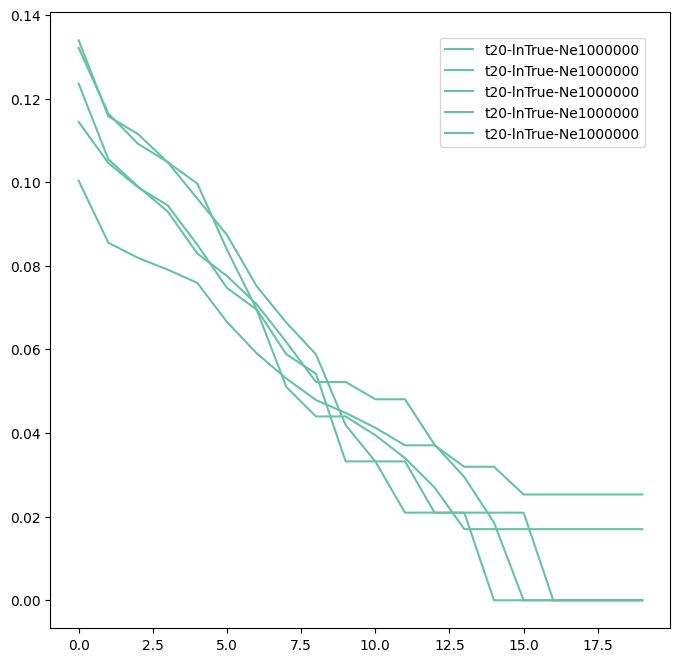

In [210]:
BCI.plot_multi(bcis, normalize=True)

## Same demography, constant Ne, but different numbers of tips from 10 - 100

wrote concat locus (100 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/jupyter-notebooks/t10-lnFalse-Ne100000.0.phy
wrote concat locus (320 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/jupyter-notebooks/t32-lnFalse-Ne100000.0.phy
wrote concat locus (550 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/jupyter-notebooks/t55-lnFalse-Ne100000.0.phy
wrote concat locus (770 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/jupyter-notebooks/t77-lnFalse-Ne100000.0.phy
wrote concat locus (1000 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/jupyter-notebooks/t100-lnFalse-Ne100000.0.phy


(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

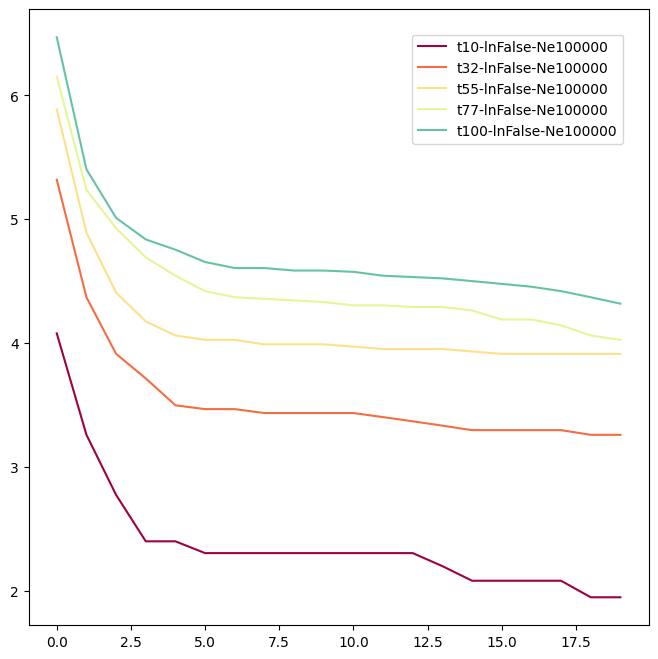

In [230]:
bcis = [sim_bci(ntips=int(x), mutation_rate=3e-8) for x in np.linspace(10, 100, 5)]
BCI.plot_multi(bcis)

(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

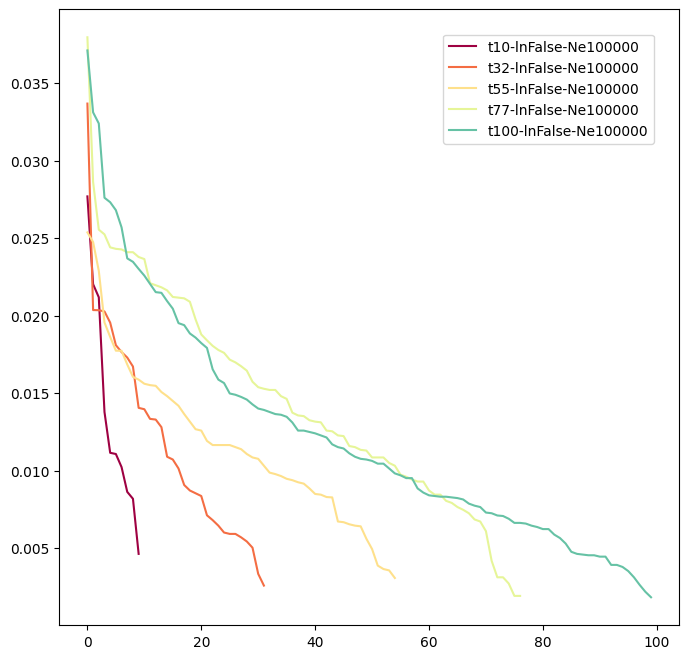

In [231]:
BCI.plot_multi(bcis, normalize=False, plot_pis=True)

## Same demography, lognormal Ne, but different numbers of tips from 10 - 100

wrote concat locus (100 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/t10-lnTrue-Ne100000.0.phy
wrote concat locus (200 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/t20-lnTrue-Ne100000.0.phy
wrote concat locus (300 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/t30-lnTrue-Ne100000.0.phy
wrote concat locus (400 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/t40-lnTrue-Ne100000.0.phy
wrote concat locus (500 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/t50-lnTrue-Ne100000.0.phy
wrote concat locus (600 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/t60-lnTrue-Ne100000.0.phy
wrote concat locus (700 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/t70-lnTrue-Ne100000.0.phy
wrote concat locus (800 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/t80-lnTrue-Ne100000.0.phy
wrote concat locus (900 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/t90-lnTrue-Ne100000.0.phy
wrote concat locus (1000 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/t100-lnTrue-Ne100000.0.phy


(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

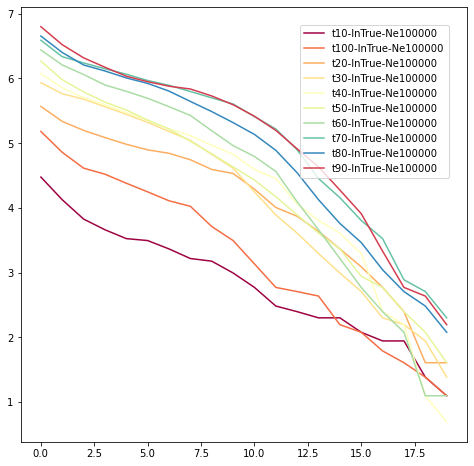

In [118]:
bcis = [sim_bci(ntips=int(x), Ne_lognormal=True) for x in np.linspace(10, 100, 10)]
BCI.plot_multi(bcis)

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

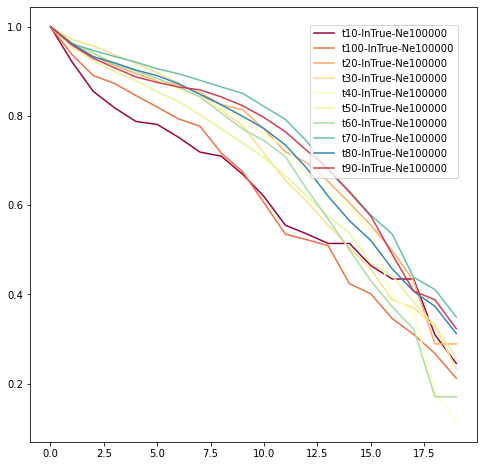

In [119]:
BCI.plot_multi(bcis, normalize=True)

## Same demography, lognormal Ne, 20 tips, varying Ne

wrote concat locus (200 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/jupyter-notebooks/t20-lnTrue-Ne10000.0.phy
wrote concat locus (200 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/jupyter-notebooks/t20-lnTrue-Ne257500.0.phy
wrote concat locus (200 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/jupyter-notebooks/t20-lnTrue-Ne505000.0.phy
wrote concat locus (200 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/jupyter-notebooks/t20-lnTrue-Ne752500.0.phy
wrote concat locus (200 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/jupyter-notebooks/t20-lnTrue-Ne1000000.0.phy


(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

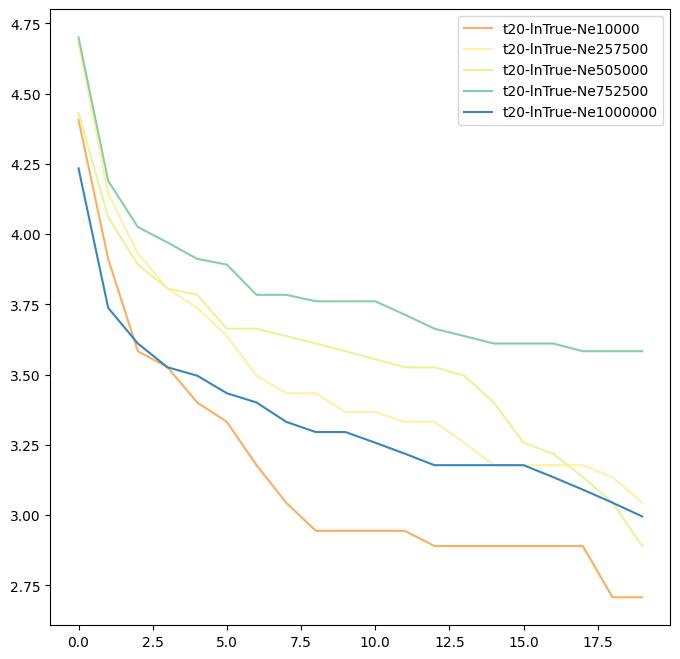

In [6]:
bcis = [sim_bci(ntips=20, Ne_lognormal=True, Ne=x) for x in np.linspace(1e4, 1e6, 5)]
BCI.plot_multi(bcis)

(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

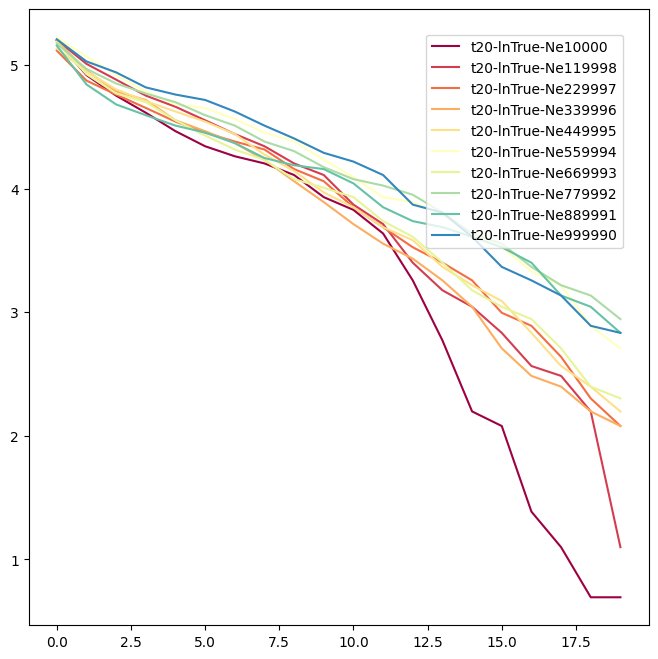

In [26]:
BCI.plot_multi(bcis, log=True, normalize=False)

### Lets add more replicates to that

wrote concat locus (200 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/jupyter-notebooks/t20-lnTrue-Ne10000.0.phy
wrote concat locus (200 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/jupyter-notebooks/t20-lnTrue-Ne257500.0.phy
wrote concat locus (200 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/jupyter-notebooks/t20-lnTrue-Ne505000.0.phy
wrote concat locus (200 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/jupyter-notebooks/t20-lnTrue-Ne752500.0.phy
wrote concat locus (200 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/jupyter-notebooks/t20-lnTrue-Ne1000000.0.phy


(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

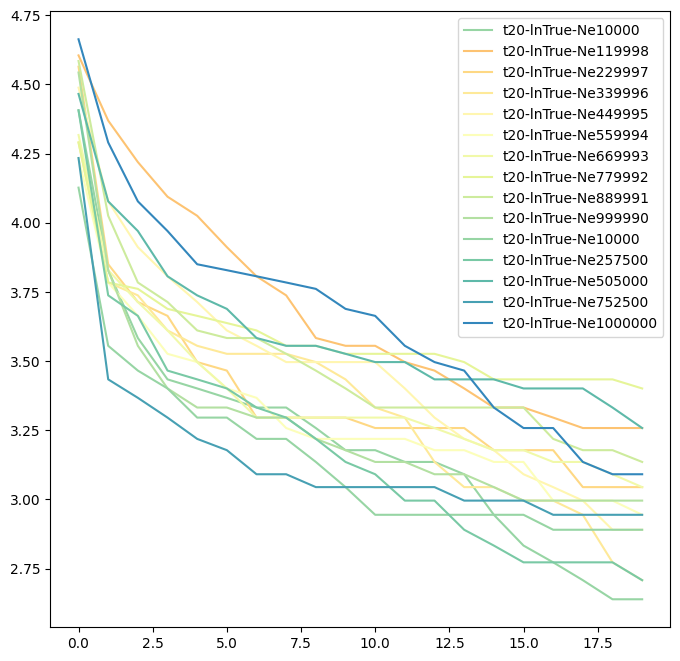

In [48]:
bcis.extend([sim_bci(ntips=20, Ne_lognormal=True, Ne=x) for x in np.linspace(1e4, 1e6, 5)])
BCI.plot_multi(bcis)

5
t20-lnTrue-Ne100000.0.fasta
dict_values([0.15297460317460343, 0.034901587301587295, 0.10086190476190483, 0.11794444444444467, 0.19227142857142906, 0.1992603174603179, 0.03353809523809522, 0.2143793650793657, 0.015866666666666668, 0.18995238095238115, 0.2797015873015876, 0.14342698412698449, 0.1727698412698416, 0.01443333333333334, 0.19628571428571454, 0.05531587301587293, 0.06882698412698414, 0.0845174603174603, 0.009911111111111114, 0.029365079365079354])
t20-lnTrue-Ne100000.0.fasta
dict_values([0.15297460317460343, 0.034901587301587295, 0.10086190476190483, 0.11794444444444467, 0.19227142857142906, 0.1992603174603179, 0.03353809523809522, 0.2143793650793657, 0.015866666666666668, 0.18995238095238115, 0.2797015873015876, 0.14342698412698449, 0.1727698412698416, 0.01443333333333334, 0.19628571428571454, 0.05531587301587293, 0.06882698412698414, 0.0845174603174603, 0.009911111111111114, 0.029365079365079354])
t20-lnTrue-Ne100000.0.fasta
dict_values([0.15297460317460343, 0.034901587301

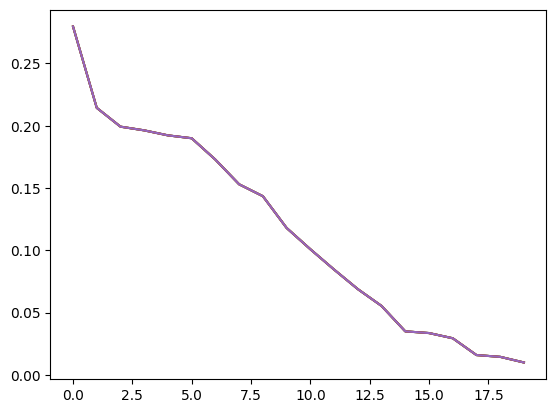

In [90]:
print(len(bcis))
list(map(lambda x: x.nucleotide_diversity(), bcis))
for bci in bcis:
    print(bci.data)
    print(bci.pis.values())
    plt.plot(sorted(bci.pis.values(), reverse=True))

# Prototyping

In [226]:
tips = tre.get_tip_labels()
# Dict {tip_name:Ne}
samps = [5]*8
Nes = {x:np.round(y) for x, y in zip(tips, samps)}
Nes

{'r0': 5, 'r1': 5, 'r2': 5, 'r3': 5, 'r4': 5, 'r5': 5, 'r6': 5, 'r7': 5}

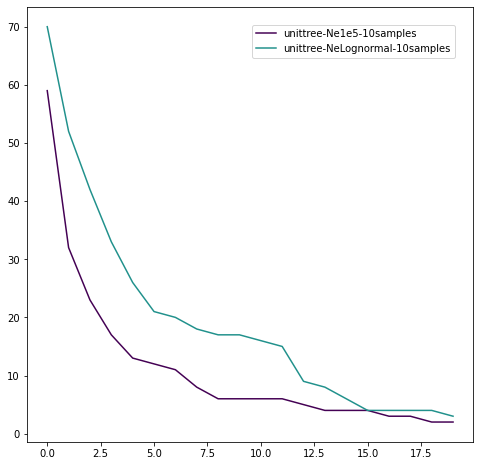

In [157]:
_ = BCI.plot_multi([bci, bci2], log=False, normalize=False, cmap="viridis")

In [167]:

def auc(bci, log=False, norm=False, verbose=False):
    d = np.array(bci.bci)
    if log: d = np.log(d)
    if norm: d = d/np.sum(d)
    if verbose: print(d)
    return np.trapz(y=bci.tols, x=d[::-1])
#    return np.trapz(y=np.arange(len(d)), x=d)
print(bci.samp, auc(bci, log=False, verbose=True))
print(bci2.samp, auc(bci2, log=False, verbose=True))

[59 32 23 17 13 12 11  8  6  6  6  6  5  4  4  4  3  3  2  2]
unittree-Ne1e5-10samples 47.257894736842104
[70 52 42 33 26 21 20 18 17 17 16 15  9  8  6  4  4  4  4  3]
unittree-NeLognormal-10samples 56.71052631578948


In [110]:
from scipy.stats import entropy
print(entropy(bci.bci, bci2.bci, base=2))
print(entropy(bci2.bci, bci.bci, base=2))

0.10646423731198598
0.09910060278524503


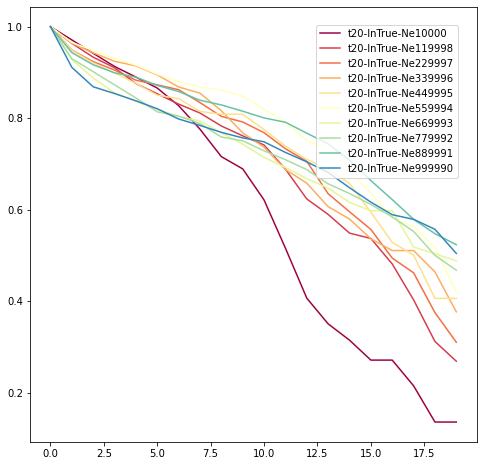

In [133]:
_ = BCI.plot_multi(bcis, log=True, normalize=True)

In [143]:
#auc(bcis[6], verbose=True)
for b in bcis:
    print(b.samp, auc(b, log=True))

t20-lnTrue-Ne10000 0.6549146427199043
t20-lnTrue-Ne119998 0.41118582185941593
t20-lnTrue-Ne229997 0.35941150355874363
t20-lnTrue-Ne339996 0.3474711624518364
t20-lnTrue-Ne449995 0.333768409067983
t20-lnTrue-Ne559994 0.26290197992522496
t20-lnTrue-Ne669993 0.36376609694824213
t20-lnTrue-Ne779992 0.35202273538712936
t20-lnTrue-Ne889991 0.2662400608496355
t20-lnTrue-Ne999990 0.3390159899193024


In [126]:
entropy(bcis[0].bci, bcis[6].bci, base=2)
#entropy(bcis[0].bci, np.ones(len(bcis[0].bci)), base=2)

0.1573007987544402

In [156]:
bcis_cyp = [sim_bci(ntips=100, Ne_lognormal=True, Ne=1e5, mutation_rate=1e-8, treeheight=1e7) for x in np.linspace(1e4, 1e6-10, 5)]


wrote concat locus (1000 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/jupyter-notebooks/t100-lnTrue-Ne100000.0.phy
wrote concat locus (1000 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/jupyter-notebooks/t100-lnTrue-Ne100000.0.phy
wrote concat locus (1000 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/jupyter-notebooks/t100-lnTrue-Ne100000.0.phy
wrote concat locus (1000 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/jupyter-notebooks/t100-lnTrue-Ne100000.0.phy
wrote concat locus (1000 x 500bp) to /home/isaac/proj/IMEMEBA-BCI/jupyter-notebooks/t100-lnTrue-Ne100000.0.phy


(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

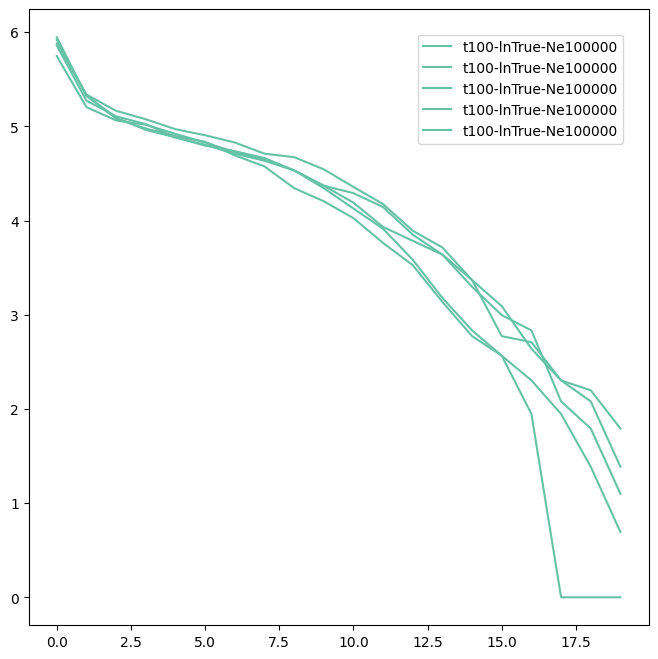

In [160]:
BCI.plot_multi(bcis_cyp, plot_pis=False)
#bcis_cyp[0].bci

In [145]:
{x:np.round(y) for x, y in zip(tips, np.random.lognormal(10, sigma=3, size=len(tips)))}

{'r0': 641.0,
 'r1': 522.0,
 'r2': 2227.0,
 'r3': 178391.0,
 'r4': 481.0,
 'r5': 91492604.0,
 'r6': 1823.0,
 'r7': 32574.0,
 'r8': 75883.0,
 'r9': 1575539.0}

In [18]:
print(len(bci.pis), bci.pis)
print(len(bci2.pis), bci2.pis)


10 {'r6_0': 0.003155555555555556, 'r2_0': 0.00588888888888889, 'r5_0': 0.006266666666666668, 'r0_0': 0.008244444444444445, 'r4_0': 0.0032666666666666673, 'r1_0': 0.0018222222222222225, 'r7_0': 0.0030888888888888884, 'r9_0': 0.005533333333333333, 'r8_0': 0.0023333333333333335, 'r3_0': 0.0013055555555555555}
18 {'r1_2': 0.023999999999999994, 'r7_2': 0.03, 'r1_7': 0.004, 'r9_5': 0.01, 'r6_3': 0.0, 'r2_8': 0.002, 'r4_4': 0.0026666666666666666, 'r5_0': 0.0018666666666666666, 'r0_0': 0.015142857142857144, 'r4_0': 0.0017142857142857142, 'r0_4': 0.008, 'r6_0': 0.0035, 'r2_0': 0.013928571428571426, 'r7_0': 0.008, 'r9_0': 0.02386666666666667, 'r8_0': 0.0010666666666666667, 'r3_0': 0.0018666666666666666, 'r1_5': 0.004}


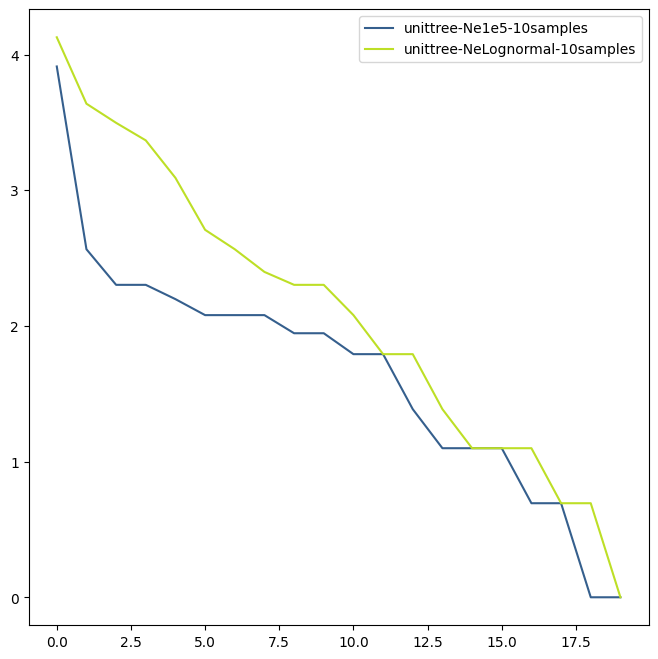

In [10]:
fix, ax = BCI.plot_multi([bci, bci2], log=True, normalize=False, cmap="viridis")

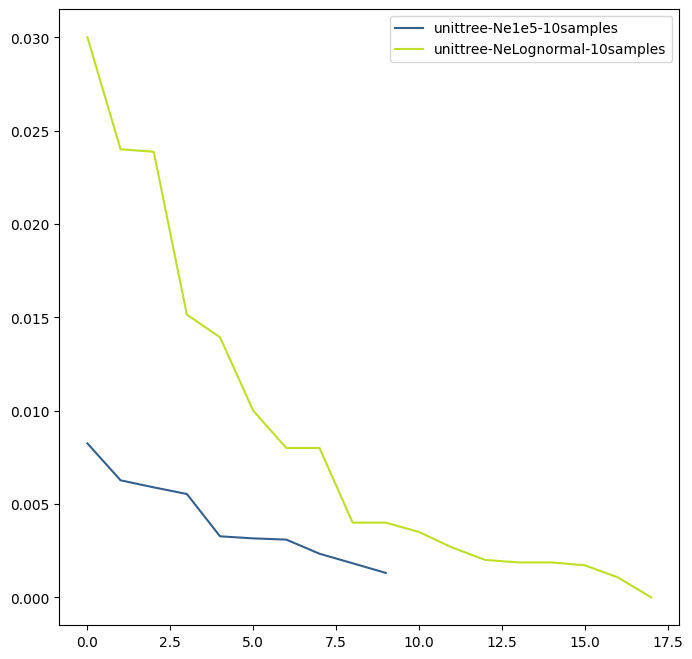

In [9]:
fix, ax = BCI.plot_multi([bci, bci2], log=True, normalize=False, cmap="viridis", plot_pis=True)

(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

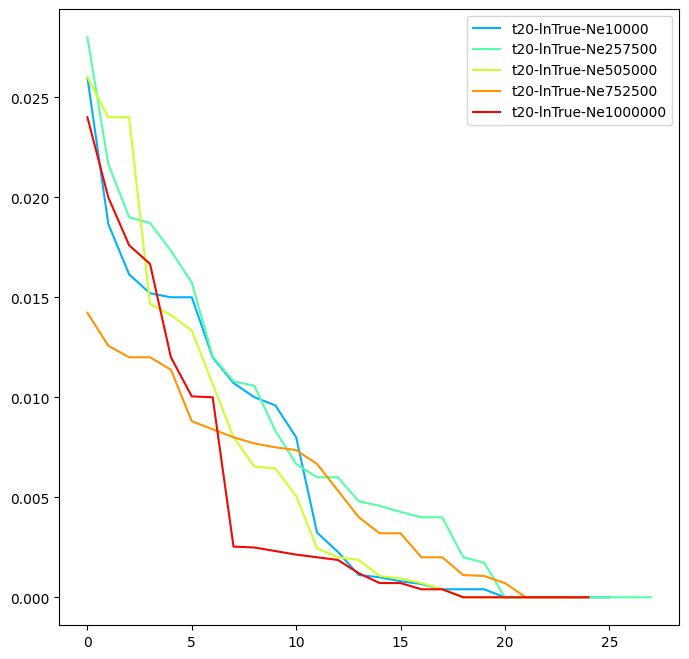

In [7]:
BCI.plot_multi(bcis, log=True, normalize=False, plot_pis=True, cmap="jet")

In [94]:
print([len(x.pis) for x in bcis])
#print(list(bcis[1].pis.values()))
pi1 = sorted(bcis[1].pis.values(), reverse=True)[:22]
pi2 = sorted(bcis[2].pis.values(), reverse=True)[:22]
print(pi1)
print(np.linalg.norm(pi1))
print(pi1/np.linalg.norm(pi1, ord=1))
print(pi2)
print(pi2/np.linalg.norm(pi2, ord=1))
np.linalg.norm([pi1, pi2])

[25, 23, 22, 32, 27]
[0.01944444444444444, 0.017200000000000003, 0.01637142857142857, 0.016355555555555554, 0.014, 0.014, 0.014, 0.012711111111111114, 0.012, 0.011200000000000002, 0.009555555555555558, 0.003911111111111111, 0.0025333333333333336, 0.002488888888888889, 0.0022666666666666664, 0.002, 0.0018666666666666666, 0.0012000000000000001, 0.0011111111111111111, 0.0, 0.0, 0.0]
0.04861050508206621
[0.11161121 0.09872809 0.09397208 0.09388097 0.08036007 0.08036007
 0.08036007 0.07296184 0.06888006 0.06428806 0.05484894 0.0224498
 0.01454135 0.01428623 0.01301068 0.01148001 0.01071468 0.00688801
 0.00637778 0.         0.         0.        ]
[0.02305555555555556, 0.0184, 0.015199999999999998, 0.013199999999999998, 0.012, 0.010577777777777778, 0.009066666666666666, 0.0028, 0.001511111111111111, 0.0014222222222222223, 0.0013333333333333335, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.21236312 0.16948112 0.14000614 0.12158428 0.11053116 0.09743117
 0.08351243 0.0257906  0.013

0.06316959414217153

In [14]:
from itertools import combinations
from scipy.stats import entropy
from scipy.spatial import distance
for b1, b2 in combinations(bcis, 2):
    print(b1.samp.split("-")[-1], b2.samp.split("-")[-1], end="\t")
    pi1 = sorted(b1.pis.values(), reverse=True)[:22]
    pi1 = pi1/np.linalg.norm(pi1, ord=1)
    pi2 = sorted(b2.pis.values(), reverse=True)[:22]
    pi2 = pi2/np.linalg.norm(pi2, ord=1)
    pi1 += 0.00000001
    pi2 += 0.00000001
    print(np.linalg.norm([pi1, pi2]), "\t", entropy(pi1, pi2), "\t", entropy(pi2, pi1),
          distance.jensenshannon(pi1, pi2))

Ne10000 Ne257500	0.4058161961748841 	 0.0735982835138051 	 0.10986968019605854 0.14569186119140184
Ne10000 Ne505000	0.4399522756320792 	 0.08590075107742072 	 0.036542855279247936 0.09739285291921854
Ne10000 Ne752500	0.3951105933418756 	 0.09952360088579562 	 0.19310013582449198 0.16835364456970683
Ne10000 Ne1000000	0.45859598374936456 	 0.18504116568212997 	 0.10561199951707245 0.17154779943543266
Ne257500 Ne505000	0.4219949035822866 	 0.3312559798619896 	 0.09376264047343498 0.16451579490732332
Ne257500 Ne752500	0.37501209952019854 	 0.027741720966369197 	 0.08586636998273742 0.08686280157742426
Ne257500 Ne1000000	0.44139774594647146 	 0.4002750254771501 	 0.14978555731319132 0.20551065823490816
Ne505000 Ne752500	0.4117102069933903 	 0.14538971623835012 	 0.409967726108919 0.20074891122184949
Ne505000 Ne1000000	0.4729727157908993 	 0.050360594157867616 	 0.04266072710946172 0.10675819225704393
Ne752500 Ne1000000	0.4315756782068966 	 0.5151860288590325 	 0.22853847444020747 0.25065837

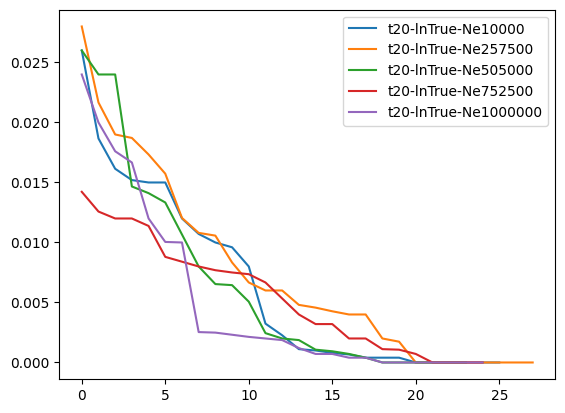

In [9]:
# Raw pi values
_ = [plt.plot(sorted(x.pis.values(), reverse=True), label=x.samp) for x in bcis]
plt.legend()

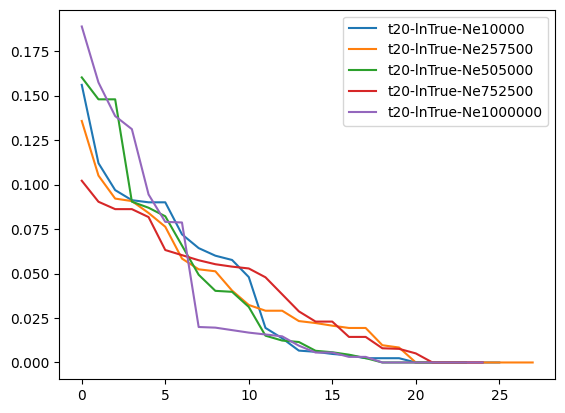

In [8]:
#normed
_ = [plt.plot(sorted(np.array(list(x.pis.values()))/np.linalg.norm(list(x.pis.values()), ord=1), reverse=True), label=x.samp) for x in bcis]
plt.legend()

0.14086266838062597 0.3297215787077525
0.1320110229033607 0.3192579960131581
0.1658294323887837 0.36042352380456016
0.15145943493973799 0.344259248062195
0.10060112406745306 0.2913637117509367


array([[0.        , 0.02886163, 0.048985  , 0.02928421, 0.08024529],
       [0.02886163, 0.        , 0.05674943, 0.03887447, 0.06586078],
       [0.048985  , 0.05674943, 0.        , 0.03717338, 0.10570169],
       [0.02928421, 0.03887447, 0.03717338, 0.        , 0.08822679],
       [0.08024529, 0.06586078, 0.10570169, 0.08822679, 0.        ]])

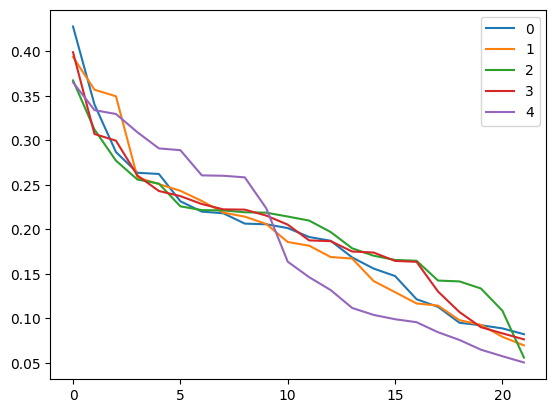

In [67]:
#tmpdata = np.linalg.norm(
tdat = []
for x in range(5):
    tmpdata = sorted(np.random.lognormal(1, sigma=0.5, size=22), reverse=True)
    tmpdata = tmpdata/np.linalg.norm(tmpdata)
    print(distance.jensenshannon(pi1, tmpdata), distance.jensenshannon(pi2, tmpdata))
    plt.plot(tmpdata, label=x)
    tdat.append(tmpdata)
plt.legend()
distance.squareform(distance.pdist(tdat, metric=distance.jensenshannon))


In [308]:
from scipy.optimize import minimize, Bounds
inarr=pi2
def find_sigma(sigma=1, inarr=None):
    dists = []
    for x in range(100):
        tmpdata = sorted(np.random.lognormal(1, sigma=sigma, size=len(inarr)), reverse=True)
        tmpdata = tmpdata/np.linalg.norm(tmpdata, ord=1)
        dist = distance.jensenshannon(inarr, tmpdata, base=2)
        dists.append(dist)
    dist = np.min(dists)
    #print(sigma, dist)
    return dist
minimize(find_sigma, 0, bounds=Bounds(0, 10), method="COBYLA", args=(inarr))

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 0.10777309245451124
       x: [ 2.156e+00]
    nfev: 20
   maxcv: 0.0

In [321]:
for bci in bcis:
    pis = sorted(bci.pis.values(), reverse=True)
    pis = pis/np.linalg.norm(pis, ord=1)
    res = minimize(find_sigma, 0.5, bounds=Bounds(0, 10), method="Powell", args=(pis))
    #print(pis)
    print(res.x, res.fun)

[6.18033989] 0.14619428522431513
[1.24570941] 0.1204710832439431
[1.80649911] 0.07875661098288834
[2.04574594] 0.10144839801610596
[2.99068781] 0.09227290182592231


In [315]:
from scipy.stats import lognorm
print(pi1)
lognorm.fit(pi1)
lognorm._fitstart(pi1)


[1.02161827e-01 9.03493669e-02 8.61990431e-02 8.61990431e-02
 8.17294636e-02 6.32126343e-02 6.03393332e-02 5.74660321e-02
 5.52312423e-02 5.38744057e-02 5.28482267e-02 4.78883617e-02
 3.83106914e-02 2.87330210e-02 2.29864188e-02 2.29864188e-02
 1.43665155e-02 1.43665155e-02 7.98140195e-03 7.66214628e-03
 5.10810085e-03 1.00000000e-08]


In [296]:
print(sorted(inarr))
distance.jensenshannon(inarr, inarr[::-1], base=2)

[1e-08, 1e-08, 1e-08, 1e-08, 0.0031479638300104928, 0.0031479638300104928, 0.005596372364463098, 0.005596372364463098, 0.009443871490031478, 0.014690461206715633, 0.015739779150052466, 0.016789097093389296, 0.01818818768450507, 0.019587278275620845, 0.019937050923399792, 0.07869885575026231, 0.07904862839804125, 0.09443862490031478, 0.13116475291710383, 0.1385099785204617, 0.15739770150052462, 0.18887723980062956]


0.9055734232377142